# Exoplanet Hunting in Deep Space
Machine Learning project on preprocessed data from the NASA Kepler space telescope. Hosted on Kaggle: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
<br>
The data is labeled and cleaned. The rows represent one solar system. Columns the flux emitted by the system over time. The data gives no information about the time between two measurements. Column "LABEL" indicates if there are exoplanets present in the system. 1 means there are no confirmed exoplanets, 2 means there is at least one confirmed exoplanet in the system.
<br>
If there are exoplanets present the flux curve shows a destingt U-shaped dip. This U-shape is the feature we are looking for

Trainset:

- 5087 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

Testset:

- 570 rows or observations.
- 3198 columns or features.
- Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
- 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

Data is highly imbalanced this needs to be taken into account
- use precision and recall

In [80]:
#import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#timer
from timeit import default_timer as timer

#scipy
from scipy.signal import savgol_filter, periodogram, spectrogram
from scipy.fftpack import fft

#sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

## Preprocessing
### Loading Data and first inspection

In [2]:
#read training data
df_train = pd.read_csv('./exoTrain.csv')
#read test data
df_test = pd.read_csv('./exoTest.csv')

#show head and info of train data
display(df_train.head(3))
df_train.info()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB


Flux values are float64 only label has int64
- Transform label into bool

In [3]:
#Check if there are really only two labels
print(df_train['LABEL'].unique())

[2 1]


In [4]:
#transform into bool (minus 1 to give 0 and 1 as labels)
df_train['LABEL'] = (df_train['LABEL'] - 1).astype('bool')
df_train['LABEL'].unique()

array([ True, False])

In [5]:
#same for test
df_test['LABEL'] = (df_test['LABEL'] - 1).astype('bool')

### Missing values

In [6]:
#Are there any missing values at all?
print(f"There are: {df_train.isna().sum().sum()} missing values")

There are: 0 missing values


### Value range and outliers

In [7]:
#min / max / mean / median values for each system
minflux = df_train.iloc[:, 1:].min(axis=1)
maxflux = df_train.iloc[:, 1:].max(axis=1)
meanflux = df_train.iloc[:, 1:].mean(axis=1)
medianflux = df_train.iloc[:, 1:].median(axis=1)

Min    flux value: -2385019.12
Max    flux value:  4299288.0
Mean   flux value:  130.41674038757083
Median flux value: 0.0


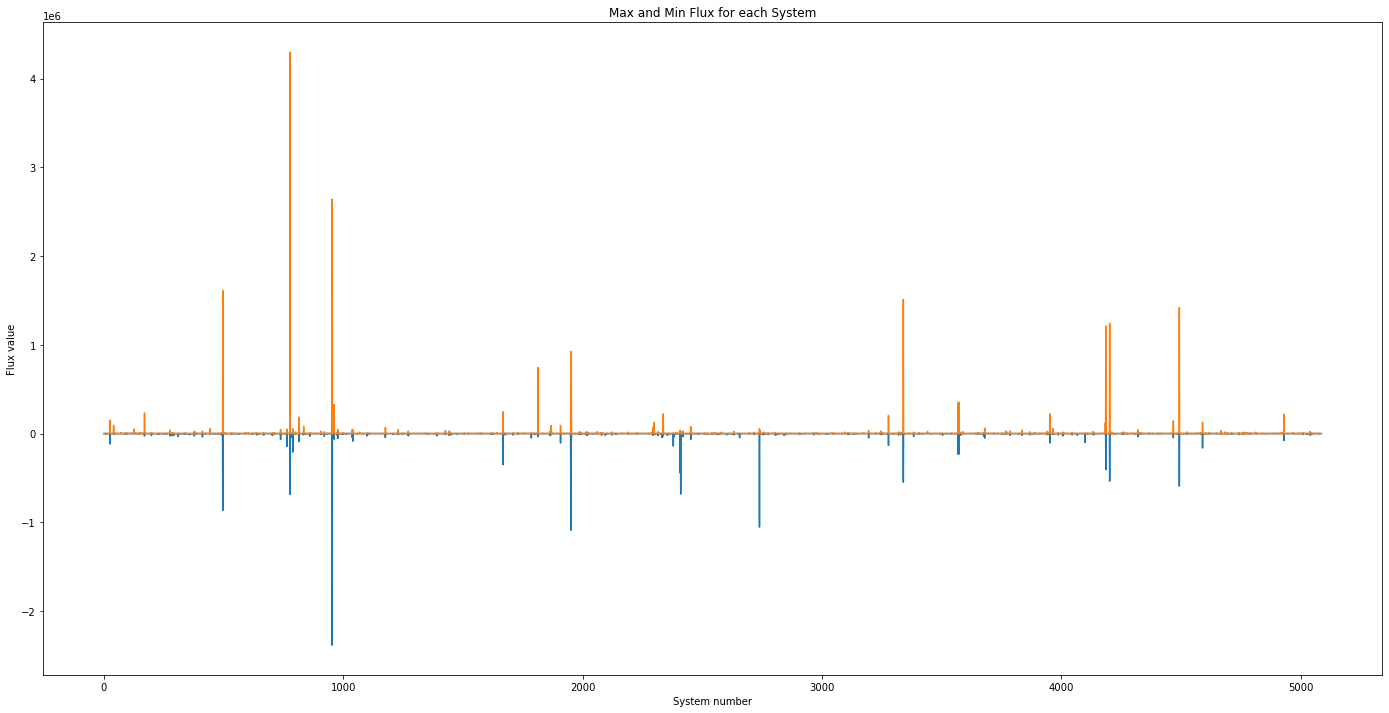

In [8]:
#plot and print min / max / mean / median values
plt.figure(figsize=(24, 12))
plt.plot(np.arange(minflux.shape[0]), minflux)
plt.plot(np.arange(maxflux.shape[0]), maxflux)
plt.title('Max and Min Flux for each System')
plt.ylabel('Flux value')
plt.xlabel('System number')
print(f"Min    flux value: {minflux.min()}")
print(f"Max    flux value:  {maxflux.max()}")
print(f"Mean   flux value:  {meanflux.mean().mean()}")
print(f"Median flux value: {medianflux.median()}")

- wide range of values
- not symmetric
- outliers maybe requiere scaling

### Sample Visualisation

In [9]:
#function to plot first 6 systems of data set
def plot_systems(X):
    plt.figure(1, figsize=(12, 6))
    for i in range(6):
        plt.subplot(2 , 3 , i+1)
        plt.scatter(np.arange(X.shape[1]), X[i], s=1)
    plt.show()

#### With Exoplanets

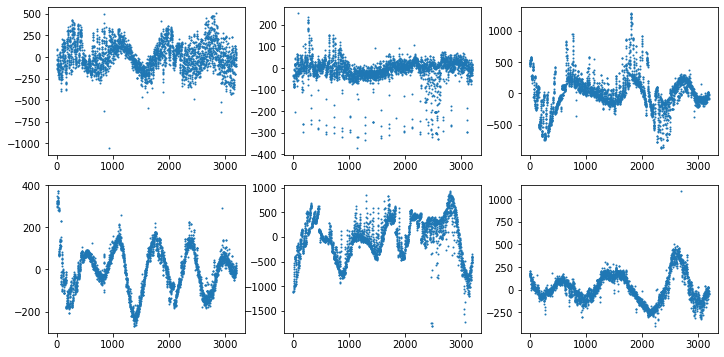

In [10]:
#plot systems with planets
tmp_df = df_train.loc[df_train['LABEL'] == True, 'FLUX.1':].values
plot_systems(tmp_df)

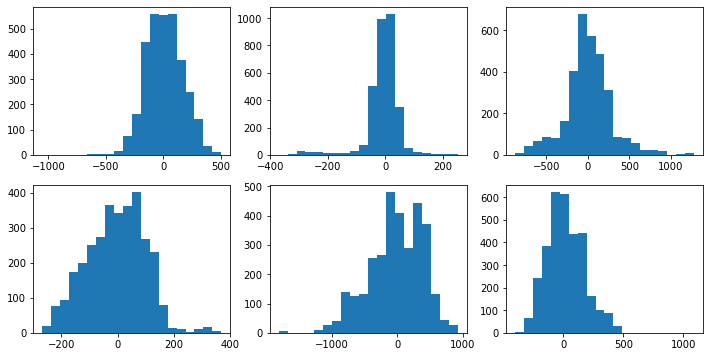

In [11]:
#plot histogram of 6 systems with planets
plt.figure(1, figsize=(12, 6))
for i in range(6):
    plt.subplot(2 , 3 , i+1)
    plt.hist(tmp_df[i], bins=20)
plt.show()

#### Without Exoplanets

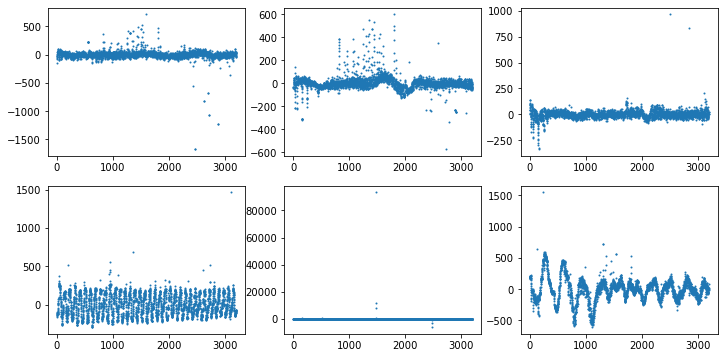

In [12]:
#plot systems without planets
tmp_df = df_train.loc[df_train['LABEL'] == False, 'FLUX.1':].values
plot_systems(tmp_df)

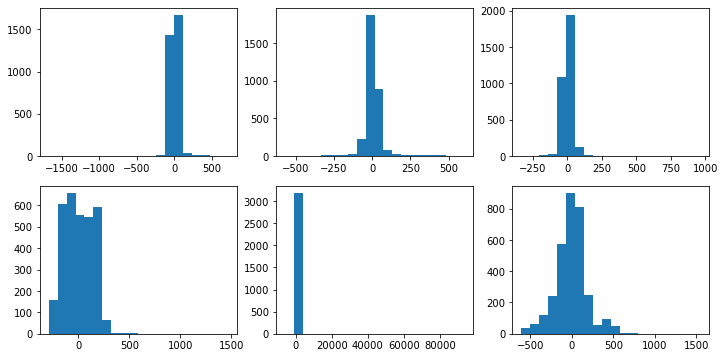

In [13]:
#plot histogram of 6 systems with planets
plt.figure(1, figsize=(12, 6))
for i in range(6):
    plt.subplot(2 , 3 , i+1)
    plt.hist(tmp_df[i], bins=20)
plt.show()

- Periodic changes visible for systems with planets
- Faster periodic changes also visible for systens wihtout planets
    - Use the frequency spectrum for the ML model?
- Noise may hide this changes
- Flux values have different magnitudes
- Histograms seem broader if there are exoplanets present
    - Could we use the histogram for the model?

## Machine Learning Model
### Baseline Models
- First check the difficulty of the problem with a couple of baseline models
    - No further preprocessing or hyperparameter tuning
    - Simple accracy score
- Split train data into train and validation data
    - For hyperparameter tuning I will use cross-validation instead
- Filter data
- Scale data with standard scaler
- Use periodogram instead of features

In [14]:
#Split into train and validate data
X = df_train.iloc[:, 1:].values
y = df_train.iloc[:, :1].values
y = y.reshape(y.shape[0])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y, random_state=1234)

In [15]:
#Seperate test data into labels and data
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, :1].values
y_test = y_test.reshape(y_test.shape[0])

In [16]:
print(f'Samples in trainings data:\t{X_train.shape[0]}\tSystems with Exoplanets: {y_train[y_train == True].shape[0]}')
print(f'Samples in validation data:\t{X_val.shape[0]}\tSystems with Exoplanets: {y_val[y_val == True].shape[0]}')

Samples in trainings data:	4069	Systems with Exoplanets: 30
Samples in validation data:	1018	Systems with Exoplanets: 7


In [56]:
#function to evaluate baseline models
def base_models(X_train, X_test, y_train, y_test):
    #list of baseline models
    model_names = [#"Logistic_Regression"
                    "Random_Forest"
                   #, "AdaBoost", "KNN"
                   , "Linear_SVC"
                   , "Naive_Bayes"]

    model_list = [#LogisticRegression()
                RandomForestClassifier()
               #, AdaBoostClassifier()
               #, KNeighborsClassifier()
               , SVC(kernel="linear")
               , GaussianNB()]  
    
    #evaluate all models
    for i, model in enumerate(model_list):
        start = timer()
        model.fit(X_train, y_train)
        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)
        print(f'Model: {model_names[i]}')
        #Use f1 Score
        print(f'Trainings  Recall-Score:\t{metrics.recall_score(y_train, y_train_predict):0.10f}')
        print(f'Validation Recall-Score:\t{metrics.recall_score(y_test, y_test_predict):0.10f}')
        end = timer()
        print(f'Elapsed Time:\t{end - start:0.4f}s\n')

#### Baseline Model on untreated data

In [24]:
#baseline on untreated data
base_models(X_train, X_val, y_train, y_val)

Model: Random_Forest
Trainings  Recall-Score:	1.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	7.9030s

Model: AdaBoost
Trainings  Recall-Score:	1.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	70.0505s

Model: KNN
Trainings  Recall-Score:	0.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	112.6136s

Model: Linear_SVC
Trainings  Recall-Score:	1.0000000000
Validation Recall-Score:	0.1428571429
Elapsed Time:	22.0870s

Model: Naive_Bayes
Trainings  Recall-Score:	0.9666666667
Validation Recall-Score:	1.0000000000
Elapsed Time:	0.5320s



- Random Forest, AdaBoost and Linear SVC are overfitting the data
- KNN and AdaBoost take to long to train
- Try to reduce overfitting of random forest
- Improve data quality by preprocessing
    - denoising
    - frequency analysis
    - PCA

#### Transformation Pipeline 
- Savitzky-Golay-Filter because it keeps distinct features of data
- Periodogram, Spectrogram, FFT (check which performs best)
- Scaling
- PCA to reduce runtime

In [42]:
#Transformer class for Filter
class SavogolFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window_length=21, polyorder=4):
        self.window_length = window_length
        self.polyorder = polyorder
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        return savgol_filter(X, window_length=self.window_length, polyorder=self.polyorder)
    
    
#Transformer class for fft
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        return np.abs(fft(X))
    
#Transformer class for periodogram
class Periodogram(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        X_perio = periodogram(X)
        return X_perio[1]
    
#Transformer class for spectrogram
class Spectrogram(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    #There is nothing happening in the fit function
    def fit(self, X, y = None):
        return self
    
    #transform data
    def transform(self, X, y = None):
        X_spec = spectrogram(X)
        return X_spec[2].mean(axis=2)   

In [92]:
#create different pipelines
transform_pipe_fft = Pipeline(steps=[
                        ('savogol_filter', SavogolFilter())
                        ,('fft', FFT())
                        ,('std_scaler', StandardScaler())
                        #,('pca', PCA(n_components=1000))
                         ])

transform_pipe_perio = Pipeline(steps=[
                        ('savogol_filter', SavogolFilter())
                        ,('periodogram', Periodogram())
                        ,('std_scaler', StandardScaler())
                        #,('pca', PCA(n_components=1000))
                         ])

transform_pipe_spec = Pipeline(steps=[
                        ('savogol_filter', SavogolFilter())
                        ,('spectrum', Spectrogram())
                        ,('std_scaler', StandardScaler())
                        #,('pca', PCA(n_components=1000))
                         ])

In [93]:
#transform data
transform_pipe_fft.fit(X_train, y_train)
X_train_fft = transform_pipe_fft.transform(X_train)
X_val_fft = transform_pipe_fft.transform(X_val)

transform_pipe_perio.fit(X_train, y_train)
X_train_perio = transform_pipe_perio.transform(X_train)
X_val_perio = transform_pipe_perio.transform(X_val)

transform_pipe_spec.fit(X_train, y_train)
X_train_spec = transform_pipe_spec.transform(X_train)
X_val_spec = transform_pipe_spec.transform(X_val)

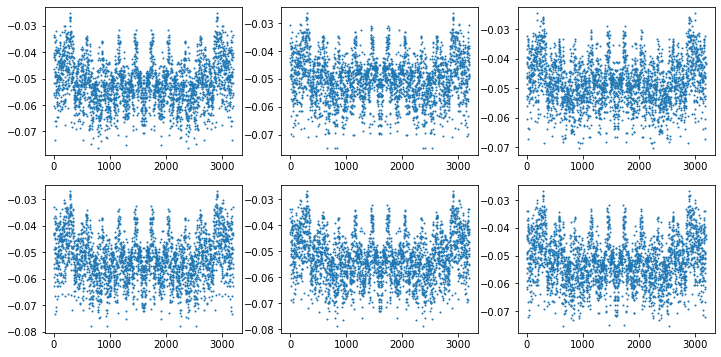

In [94]:
#check pipelines
plot_systems(X_train_fft)

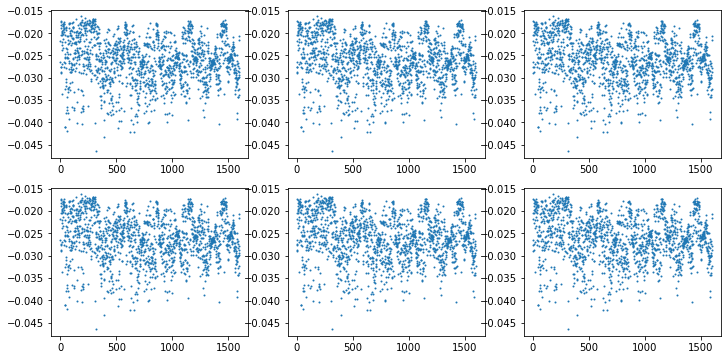

In [95]:
plot_systems(X_train_perio)

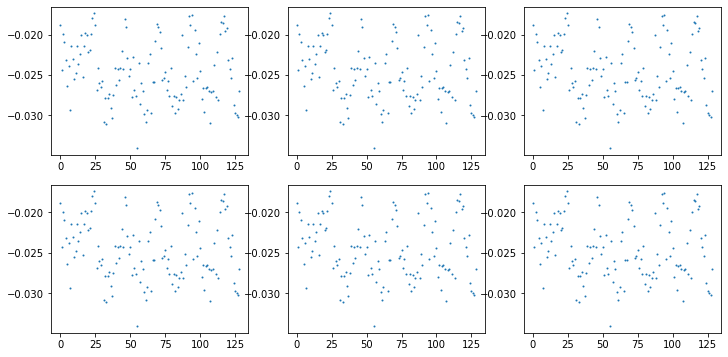

In [96]:
plot_systems(X_train_spec)

In [97]:
#Check base models
base_models(X_train_fft, X_val_fft, y_train, y_val)

Model: Random_Forest
Trainings  Recall-Score:	1.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	8.8005s

Model: Linear_SVC
Trainings  Recall-Score:	0.1333333333
Validation Recall-Score:	0.0000000000
Elapsed Time:	5.9282s

Model: Naive_Bayes
Trainings  Recall-Score:	0.9666666667
Validation Recall-Score:	1.0000000000
Elapsed Time:	0.3806s



In [98]:
base_models(X_train_perio, X_val_perio, y_train, y_val)

Model: Random_Forest
Trainings  Recall-Score:	1.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	6.4171s

Model: Linear_SVC
Trainings  Recall-Score:	0.0333333333
Validation Recall-Score:	0.0000000000
Elapsed Time:	1.4374s

Model: Naive_Bayes
Trainings  Recall-Score:	0.9666666667
Validation Recall-Score:	1.0000000000
Elapsed Time:	0.1845s



In [99]:
base_models(X_train_spec, X_val_spec, y_train, y_val)

Model: Random_Forest
Trainings  Recall-Score:	0.7333333333
Validation Recall-Score:	0.0000000000
Elapsed Time:	5.2471s

Model: Linear_SVC
Trainings  Recall-Score:	0.0000000000
Validation Recall-Score:	0.0000000000
Elapsed Time:	0.1075s

Model: Naive_Bayes
Trainings  Recall-Score:	0.9666666667
Validation Recall-Score:	1.0000000000
Elapsed Time:	0.0161s



### Gaussian Naive Bayes

In [106]:
transform_pipe_perio.fit(X)
X_perio = transform_pipe_perio.transform(X)

In [108]:
nb_cv = cross_val_score(GaussianNB(), X=X_perio, y=y, cv=10, n_jobs=-1, verbose=5, scoring='recall')
print(f"Cross Val Score: {nb_cv}")
print(f"Mean Cross Val Score: {nb_cv.mean()} +- {nb_cv.std()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.1s finished


Cross Val Score: [1.   1.   1.   1.   1.   1.   0.75 1.   1.   1.  ]
Mean Cross Val Score: 0.975 +- 0.075


### XGB

In [109]:
xgb_cv = cross_val_score(XGBClassifier(), X=X_perio, y=y, cv=10, n_jobs=-1, verbose=5, scoring='recall')
print(f"Cross Val Score: {xgb_cv}")
print(f"Mean Cross Val Score: {xgb_cv.mean()} +- {xgb_cv.std()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.8min remaining:   47.4s


Cross Val Score: [0.25       0.25       0.         0.25       0.         0.
 0.         0.         0.         0.33333333]
Mean Cross Val Score: 0.10833333333333332 +- 0.1346291201783626


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished


### Random Forest

In [110]:
rd_forest = RandomForestClassifier(n_estimators=2000, max_depth=100)
rd_forest_cv = cross_val_score(rd_forest, X=X_perio, y=y, cv=10, n_jobs=-1, verbose=5, scoring='recall')
print(f"Cross Val Score: {rd_forest_cv}")
print(f"Mean Cross Val Score: {rd_forest_cv.mean()} +- {rd_forest_cv.std()}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  6.7min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  6.7min remaining:  2.9min


Cross Val Score: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean Cross Val Score: 0.0 +- 0.0


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.0min finished


In [46]:
#lists of hyperparameters to tune
random_params = {'criterion': ['entropy', 'gini']
                , 'max_depth' : [10, 100, 1000, None]
                , 'n_estimators' : [50, 100, 200, 500]
                , 'min_samples_leaf' : [1, 5, 10]
                , 'min_samples_split': [5, 10, 15]
                , 'max_features' : ['auto', 'log2']}

In [47]:
#random search
forest_random_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=random_params,
                                      scoring='recall', n_iter=100, cv=5, n_jobs=-1, verbose=10, random_state=4321)
forest_random_cv.fit(X_fft, y)

y_predict = forest_random_cv.predict(X_fft)
#Use recall Score
print(f'Confusion Matrix:\n{metrics.confusion_matrix(y, y_predict)}')
print(f'Classification report:\n{metrics.classification_report(y, y_predict)}')
print(f'Best model: {forest_random_cv.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Confusion Matrix:
[[5050    0]
 [  37    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      5050
        True       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087

Best model: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'entropy'}


/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
#lists of hyperparameters to tune
grid_params = {'criterion': [forest_random_cv.best_params_['criterion']]
                , 'max_features' : [forest_random_cv.best_params_['max_features']]
                ,'n_estimators' : [forest_random_cv.best_params_['n_estimators']]                   
                , 'max_depth' : [forest_random_cv.best_params_['max_depth'] - 5
                                , forest_random_cv.best_params_['max_depth']
                                , forest_random_cv.best_params_['max_depth'] + 5]
                , 'min_samples_leaf' : [forest_random_cv.best_params_['min_samples_leaf'] - 2
                                       , forest_random_cv.best_params_['min_samples_leaf']
                                       , forest_random_cv.best_params_['min_samples_leaf'] + 2]
                , 'min_samples_split': [forest_random_cv.best_params_['min_samples_split'] - 3
                                       , forest_random_cv.best_params_['min_samples_split']
                                       , forest_random_cv.best_params_['min_samples_split'] + 3]
              }

#grid search
forest_grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid_params,
                              scoring='recall', cv=5, n_jobs=-1, verbose=10)
forest_grid_cv.fit(X_trans, y)

y_predict = forest_random_cv.predict(X_trans)
print(f'Confusion Matrix:\n{metrics.confusion_matrix(y, y_predict)}')
print(f'Classification report:\n{metrics.classification_report(y, y_predict)}')
print(f'Best model: {forest_grid_cv.best_params_}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   58.1s finished


Confusion Matrix:
[[5050    0]
 [  37    0]]
Classification report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      5050
        True       0.00      0.00      0.00        37

    accuracy                           0.99      5087
   macro avg       0.50      0.50      0.50      5087
weighted avg       0.99      0.99      0.99      5087

Best model: {'criterion': 'entropy', 'max_depth': 95, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 500}


/home/clemens/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
